In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
os.getcwd()

'/home/vizziwo/capcookie/models'

In [8]:
X_train = pd.read_csv('../data/processed/X2_train.csv', index_col=0)
X_test = pd.read_csv('../data/processed/X2_test.csv', index_col=0)
y_train = pd.read_csv('../data/processed/y2_train.csv', index_col=0)
y_test = pd.read_csv('../data/processed/y2_test.csv', index_col=0)

In [9]:
X_train.head()

,signs_of_mental_illness,body_camera,gender_F,gender_M,threat_level_attack,threat_level_not_attack,threat_level_unspecified,flee_Car,flee_Foot,flee_Not fleeing,...,armed_knife,armed_machete,armed_other,armed_sword,armed_toy weapon,armed_unarmed,armed_undetermined,armed_unknown weapon,armed_vehicle,standardized_age
2836,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.740107
1157,1,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.504791
744,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0.269475
1448,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0.583230
3339,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.907106


In [10]:
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_confusion_matrix, f1_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


## SVM, Hyperparameter Tuning

In [219]:
from timeit import default_timer as timer

start = timer()

cw = ['balanced', None]

# svm.coef_ attribute is only availabel on linear kernels, so...
kernel = ['linear']

C = [0.01, .1, 1, 10, 100, 1000]
gamma = ['scale','auto']
grid = dict(class_weight=cw, kernel=kernel, C=C, gamma=gamma)

model = SVC()

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, 
                           cv=5, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

end=timer()
print('time:', end-start)

time: 2007.386069602042


In [220]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

scores=[]
parameters=[]

for mean, stdev, param in zip(means, stds, params):
    scores.append(mean)
    parameters.append(param)
    
scores= np.array(scores)
params=np.array(params)
scores.argsort()[-10:]

ps = params[scores.argsort()[-10:]]
ss = scores[scores.argsort()[-10:]]

for p, s in zip(ps, ss):
    print(s, ':', p)

0.655485214655701 : {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.655485214655701 : {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.6599846574881201 : {'C': 1000, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.6599846574881201 : {'C': 1000, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.6608941645800457 : {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.6608941645800457 : {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.6608954502536536 : {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.6608954502536536 : {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.661085322358 : {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.661085322358 : {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}


time= 35.35371153202141
f1 score: 0.6529266281945589


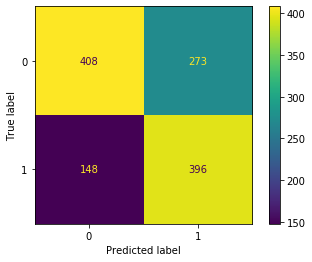

In [11]:
from timeit import default_timer as timer
start = timer()

#Best: 0.661085 using {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
svc= SVC(C=10, class_weight='balanced', gamma='scale', kernel='linear', probability=True, random_state=2)

#fit training set
svc.fit(X_train, y_train)
y_predict_svc = svc.predict(X_test)

#scores svc
predprob = svc.predict_proba(X_test)[:,1]
Accuracy_svc=svc.score(X_test,y_test)
f1_svc = f1_score(y_test, y_predict_svc)
recall_svc = recall_score(y_test, y_predict_svc)
auc_svc = roc_auc_score(y_test, predprob)


end = timer()
print('time=', end-start)
print('f1 score:', f1_svc)
plot_confusion_matrix(svc, X_test, y_test)

f1_original = f1_svc

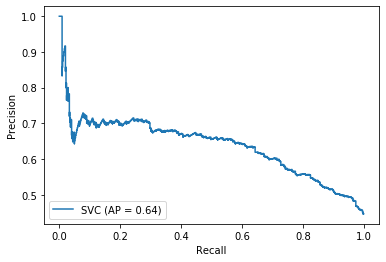

In [13]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(svc, X_test, y_test)

In [14]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(20,20))
    plt.rc('ytick', labelsize=20) 
    plt.rc('xtick', labelsize=20)
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.rc('axes', titlesize=20)     # fontsize of the axes title
    plt.rc('axes', labelsize=20)   # fontsize of the x and y labels
    plt.title('Feature Importances for Tuned SVC Model')
    plt.xlabel('Size of Coefficient')
    plt.ylabel('Name of Feature')
    plt.show()

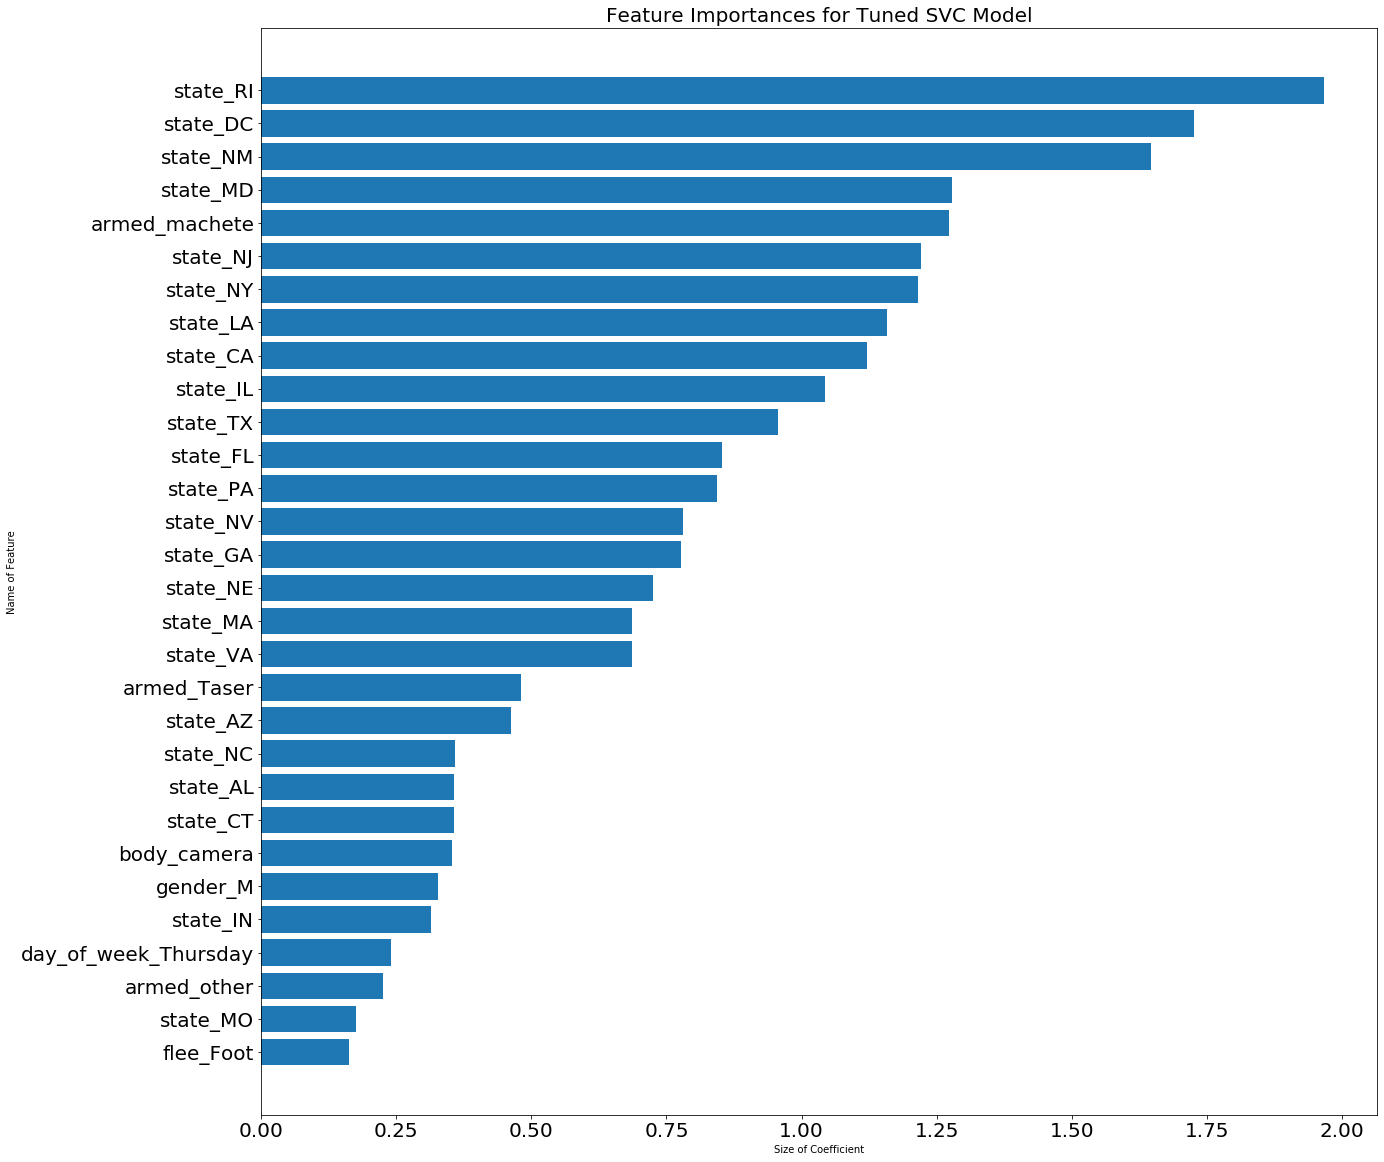

In [15]:
feature_names = X_test.columns[svc.coef_.argsort()[0, -30:]]
importances = np.sort(svc.coef_)[0, -30:]
f_importances(importances, feature_names)

#### This model has a relatively high F1 score and the feature importances that are readable.  Its highlighted features overlap quite a bit with those of Logistic Regression models.

## Retuning the model with a lower C value to reduce the size of coefficients and highlight most important features.

time= 11.89121240802342
f1 score: 0.6505016722408027


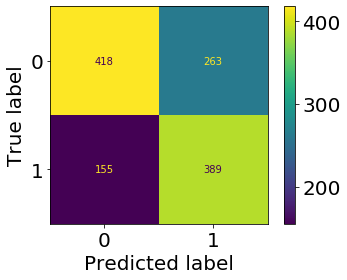

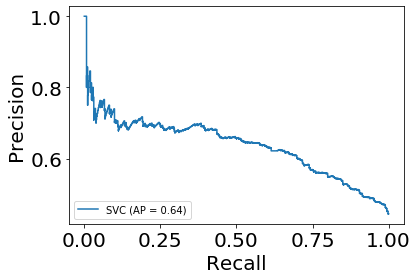

In [16]:
from timeit import default_timer as timer
start = timer()

#Best: 0.661085 using {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
svc= SVC(C=.1, class_weight='balanced', gamma='scale', kernel='linear', probability=True, random_state=2)

#fit training set
svc.fit(X_train, y_train)
y_predict_svc = svc.predict(X_test)

#scores svc
predprob = svc.predict_proba(X_test)[:,1]
Accuracy_svc=svc.score(X_test,y_test)
f1_svc = f1_score(y_test, y_predict_svc)
recall_svc = recall_score(y_test, y_predict_svc)
auc_svc = roc_auc_score(y_test, predprob)


end = timer()
print('time=', end-start)
print('f1 score:', f1_svc)
plot_confusion_matrix(svc, X_test, y_test)
plot_precision_recall_curve(svc, X_test, y_test)

f1_score_retuned = f1_svc

#### Retuned SVC Model with Lower C Value: Visualizing Feature Importances

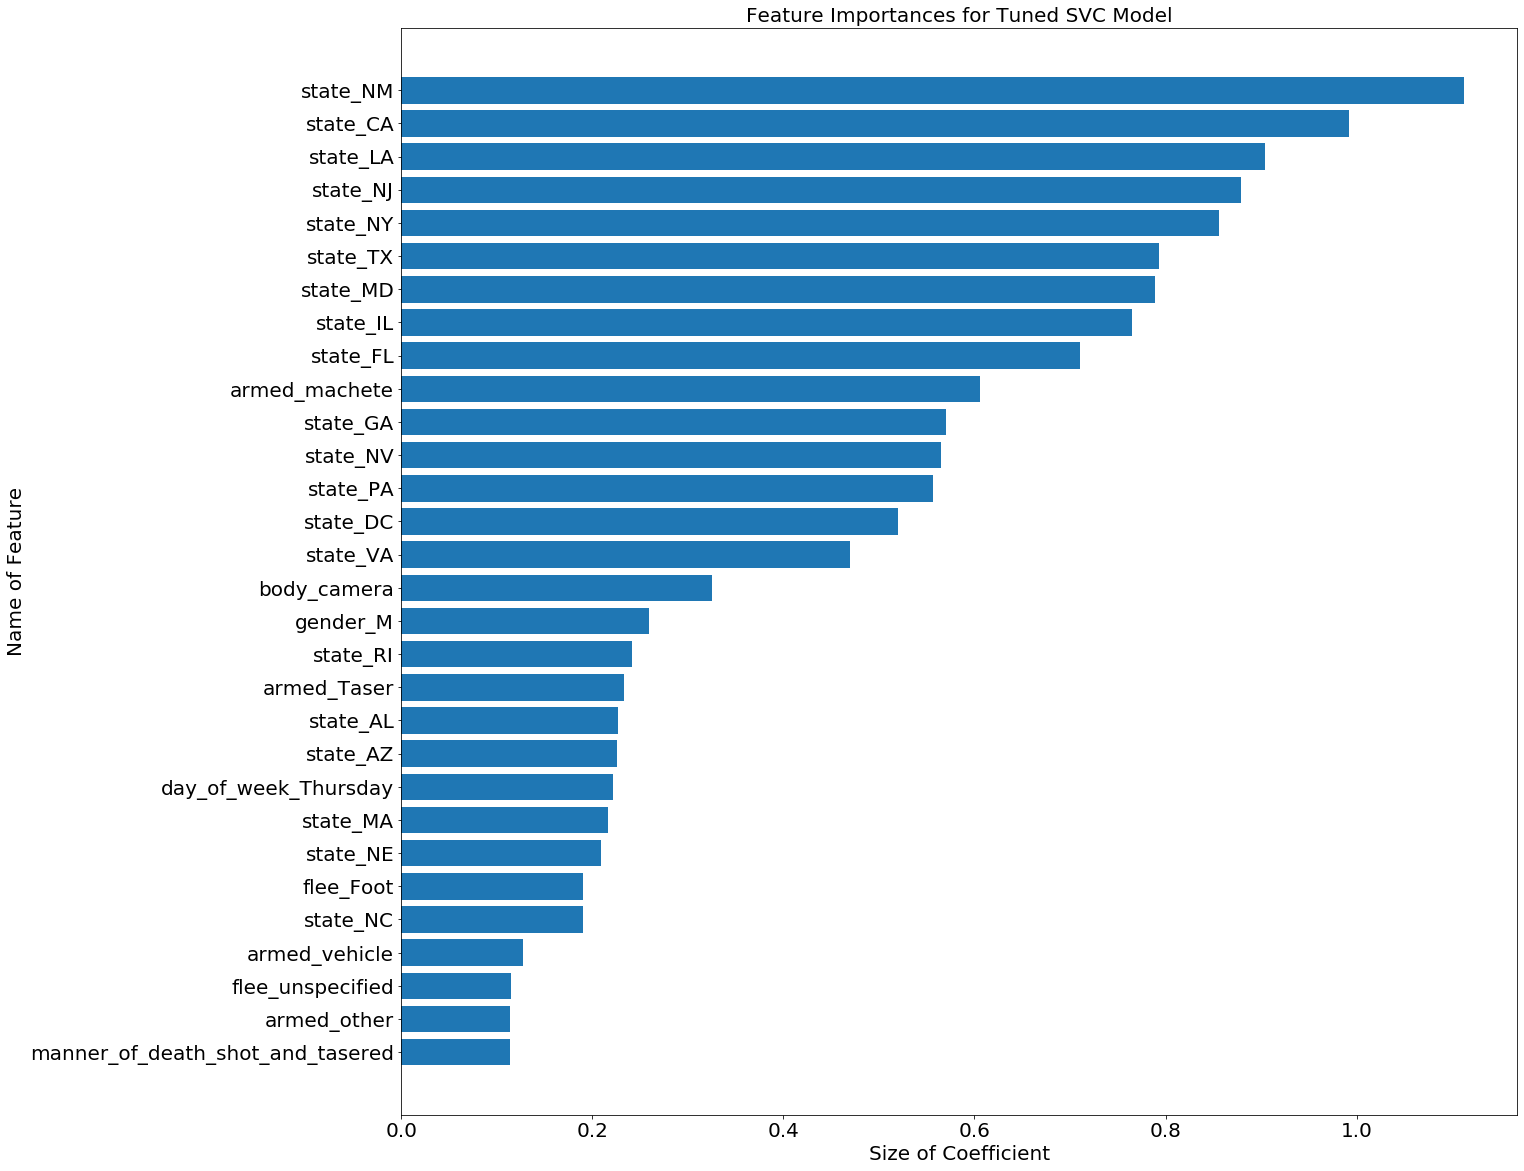

In [17]:
feature_names = X_test.columns[svc.coef_.argsort()[0, -30:]]
importances = np.sort(svc.coef_)[0, -30:]
f_importances(importances, feature_names)

#### This doesn't change the model significantly. The F1 Score is almost as high and the top features include the same states but a slightly altered order.

## Resampling to Create More from Less Represented Class (Positive Class)

In [18]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.values)

## Grid search on resampled data

In [228]:
from timeit import default_timer as timer

start = timer()

cw = ['balanced']

# svm.coef_ attribute is only availabel on linear kernels, so...
kernel = ['linear']

C = [0.01, .1, 1, 10, 100, 1000]
gamma = ['scale','auto']
grid = dict(class_weight=cw, kernel=kernel, C=C, gamma=gamma)

model = SVC()

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, 
                           cv=5, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_res, y_train_res)

end=timer()
print('time:', end-start)

time: 1020.7284823509981


In [229]:
scores=[]
parameters=[]

for mean, stdev, param in zip(means, stds, params):
    scores.append(mean)
    parameters.append(param)
    
scores= np.array(scores)
params=np.array(params)

ps = params[scores.argsort()[-10:]]
ss = scores[scores.argsort()[-10:]]

for p, s in zip(ps, ss):
    print(s, ':', p)

0.655485214655701 : {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.655485214655701 : {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.6599846574881201 : {'C': 1000, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.6599846574881201 : {'C': 1000, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.6608941645800457 : {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.6608941645800457 : {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.6608954502536536 : {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.6608954502536536 : {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
0.661085322358 : {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
0.661085322358 : {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}


## Predicting on Test Data with Retuned Model, trained on Resampled Data

time: 24.702488536015153
f1 score: 0.6334519572953737


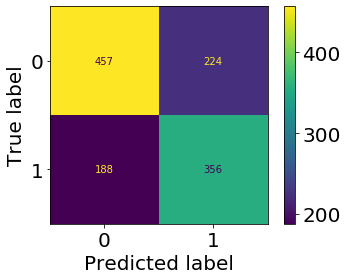

In [19]:
start= timer()

svc= SVC(C=10, class_weight='balanced', gamma='scale', kernel='linear', probability=True)

#fit resampled data
svc.fit(X_train_res, y_train_res)
y_predict_svc_res = svc.predict(X_test)

#scores svc_resampled
predprob = svc.predict_proba(X_test)[:,1]
Accuracy_svc_res=svc.score(X_test,y_test)
f1_svc_res = f1_score(y_test, y_predict_svc_res)
recall_svc_res = recall_score(y_test, y_predict_svc_res)
auc_svc_res = roc_auc_score(y_test, predprob)

end=timer()
print('time:',end-start)

print('f1 score:', f1_svc_res)
plot_confusion_matrix(svc, X_test, y_test)

f1_resampled = f1_svc_res

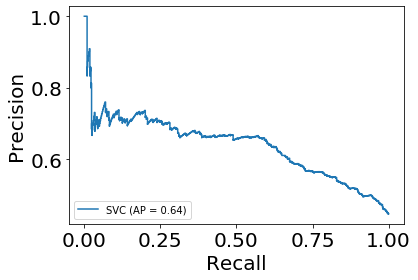

In [20]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(svc, X_test, y_test)

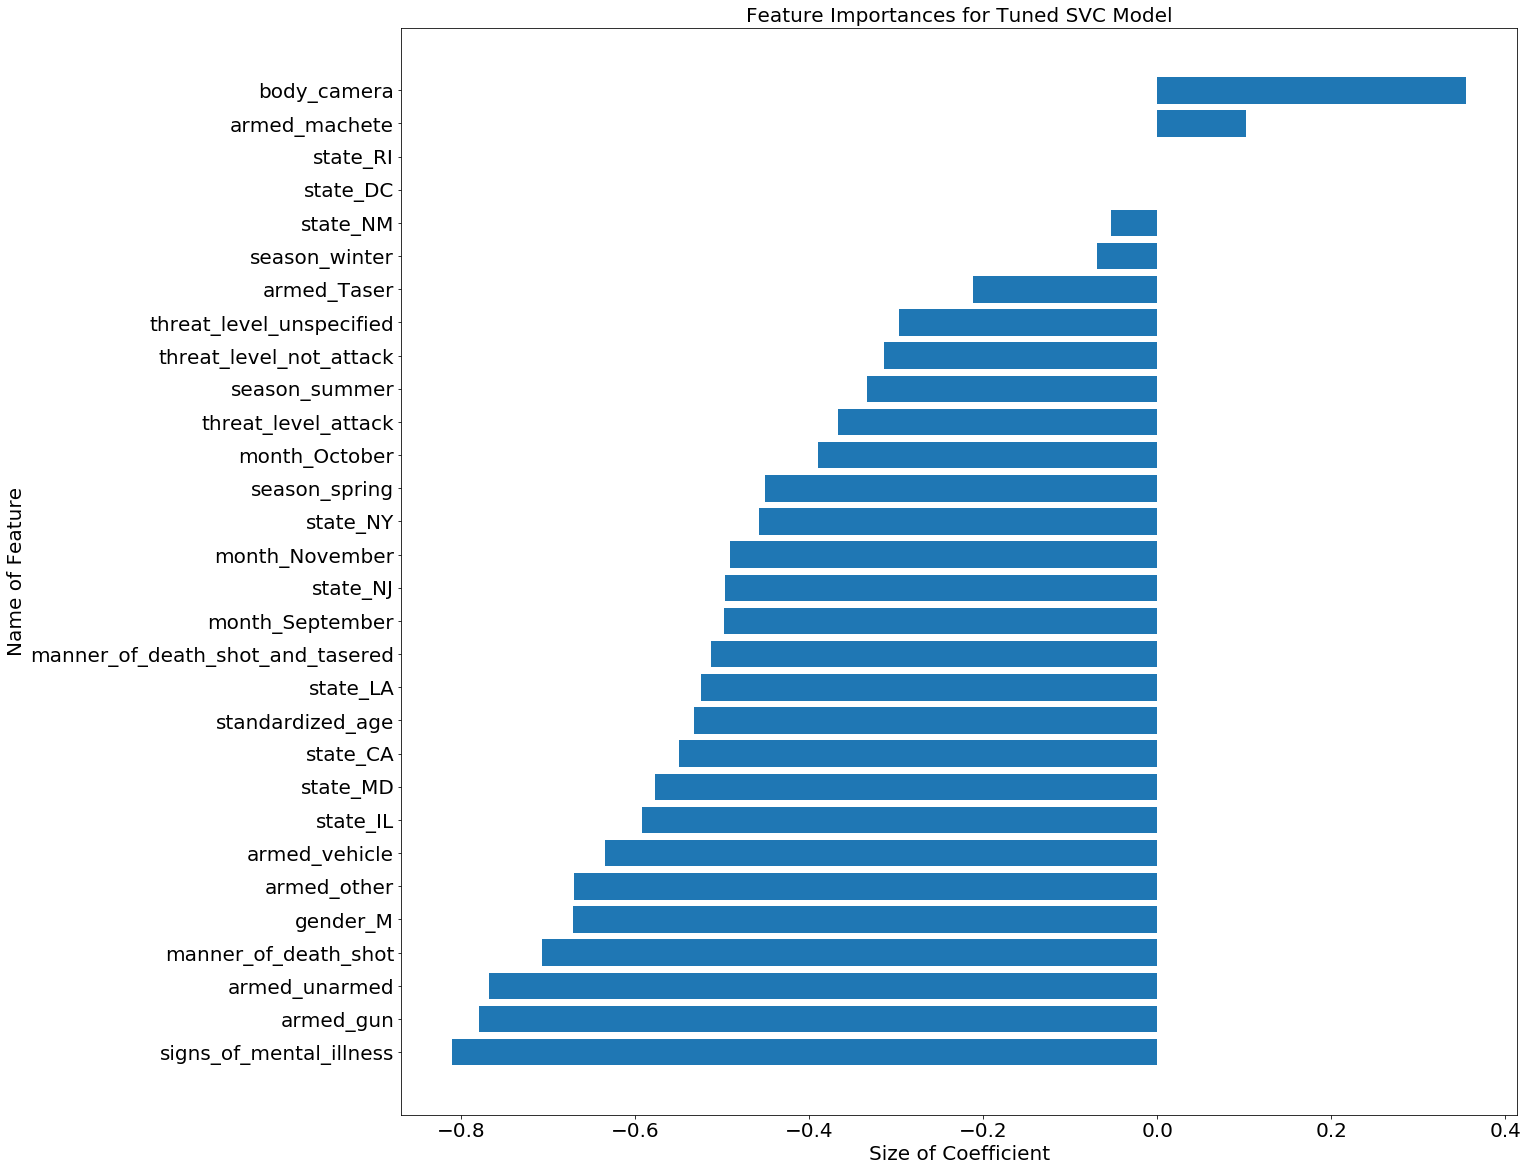

In [21]:
feature_names = X_test.columns[svc.coef_.argsort()[0, -30:]]
importances = np.sort(svc.coef_)[0, -30:]
f_importances(importances, feature_names)

####  It is hard to read this because of so many negative coefficients. 
## Retuning the model with a lower C value to regularize the line.

time: 15.060898646013811
f1 score: 0.6409597257926307


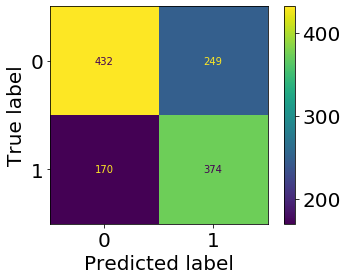

In [22]:
start= timer()

svc= SVC(C=.1, class_weight='balanced', gamma='scale', kernel='linear', probability=True, random_state=2)

#fit resampled data
svc.fit(X_train_res, y_train_res)
y_predict_svc_res = svc.predict(X_test)

#scores svc_resampled
predprob = svc.predict_proba(X_test)[:,1]
Accuracy_svc_res=svc.score(X_test,y_test)
f1_svc_res = f1_score(y_test, y_predict_svc_res)
recall_svc_res = recall_score(y_test, y_predict_svc_res)
auc_svc_res = roc_auc_score(y_test, predprob)

end=timer()
print('time:',end-start)

print('f1 score:', f1_svc_res)
plot_confusion_matrix(svc, X_test, y_test)

f1_resampled_retuned = f1_svc_res

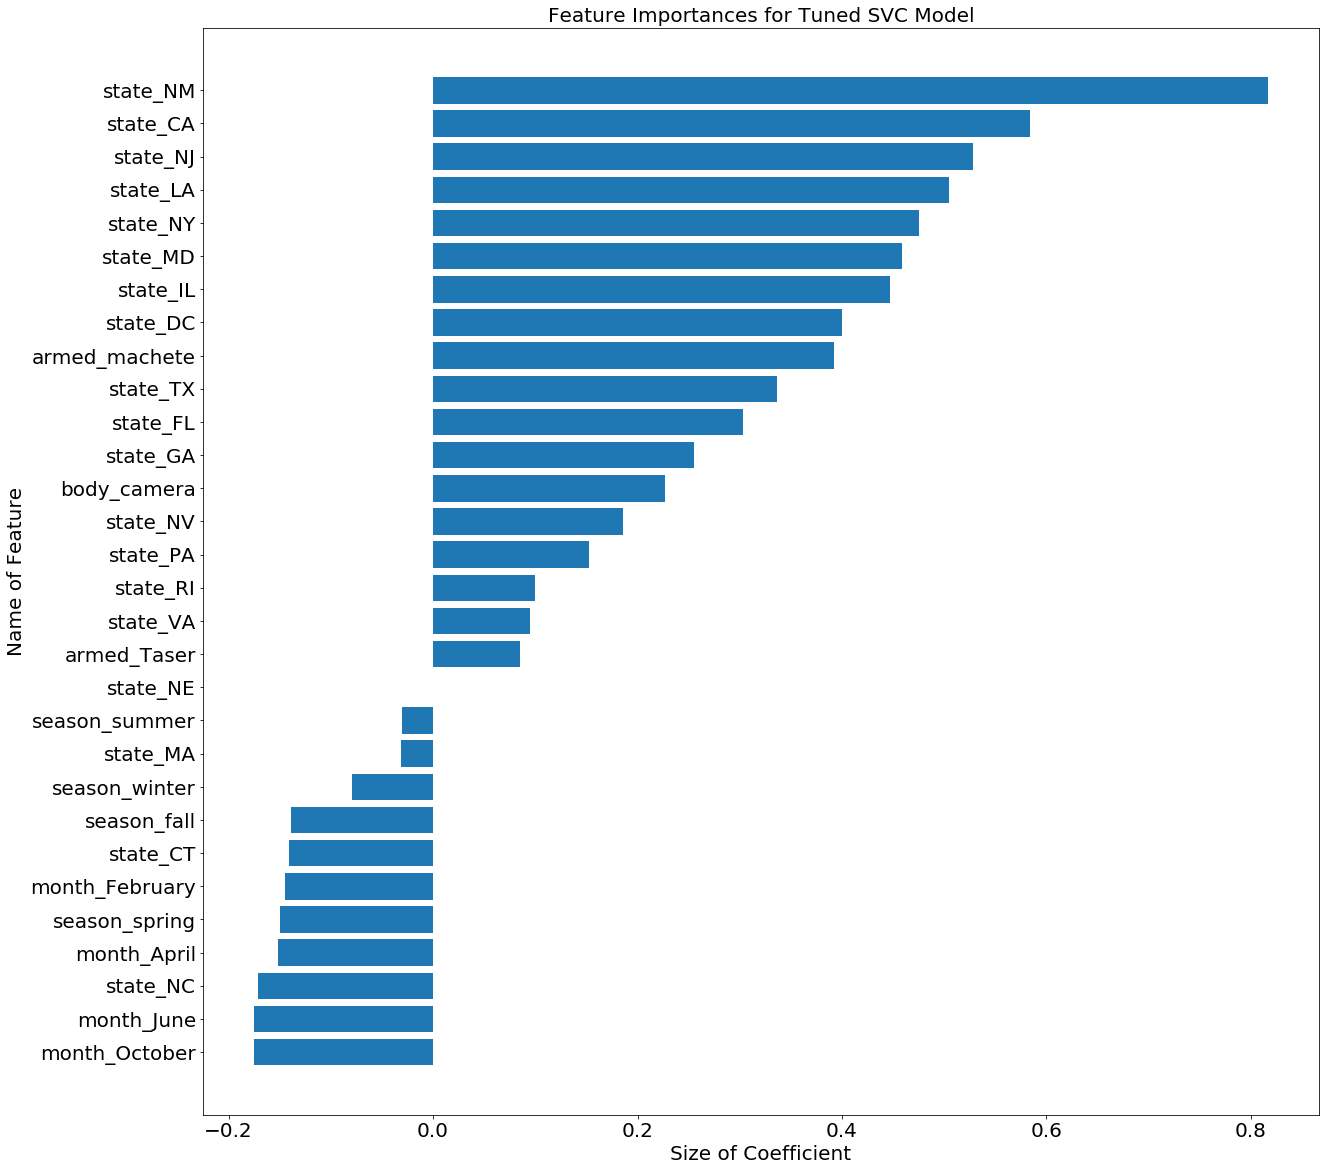

In [23]:
feature_names = X_test.columns[svc.coef_.argsort()[0, -30:]]
importances = np.sort(svc.coef_)[0, -30:]
f_importances(importances, feature_names)

#### The F1 Score for this regularized model was higher and the feature importances are easier to read. It also coincides with the features highlight by the Logistic Regression model. There is some overlap with the important features from the first SVC model that I made without the resampled data.

#### Summary of SVC:

In [24]:
print('Tuned model:', f1_original)
print('Retuned with low C value:', f1_score_retuned)
print('Post-resampling tuned model:',f1_resampled)
print('Post-resampling with low C value:', f1_resampled_retuned)

Tuned model: 0.6529266281945589
Retuned with low C value: 0.6505016722408027
Post-resampling tuned model: 0.6334519572953737
Post-resampling with low C value: 0.6409597257926307


# RANDOM FOREST: Hyperparameter Tuning

#### Plotting the effects of hyperparameters on the model to help determine the values tested in GridSearch 

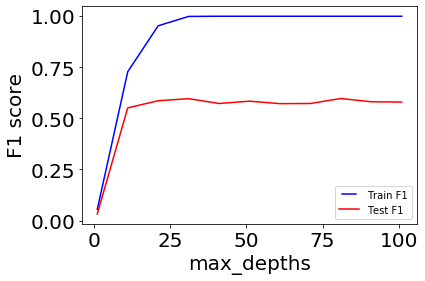

In [25]:
from sklearn.metrics import f1_score
max_depths = np.arange(1, 111, 10)
x_train = X_train
x_test = X_test
train_results = []
test_results = []
for max_depth in max_depths:
    model = RandomForestClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train F1')
line2, = plt.plot(max_depths, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_depths')
plt.show()


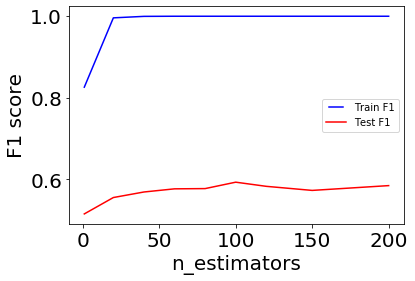

In [26]:
x_train = X_train
x_test = X_test
n_estimators = [1, 20, 40, 60, 80, 100, 120, 150, 200]
train_results = []
test_results = []
for n_estimator in n_estimators:
    model = RandomForestClassifier(n_estimators=n_estimator)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()


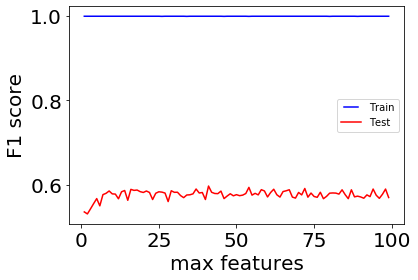

In [27]:
x_train = X_train
x_test = X_test
max_features = list(range(1,100))
train_results = []
test_results = []
for max_feature in max_features:
    model = RandomForestClassifier(max_features=max_feature)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train')
line2, = plt.plot(max_features, test_results, 'r', label='Test')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max features')
plt.show()


### Tuning Random Forest Using GridSearch, based on information learned from above plots

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from timeit import default_timer as timer

start = timer()
model = RandomForestClassifier()
max_depth = [5,10,20,30,40]
criterion=['gini','entropy']
n_estimators = [25, 50, 100, 150, 200]
max_features= [5, 10, 20, 40, 60, 80]
class_weight=['balanced']
grid = dict(max_depth=max_depth, n_estimators=n_estimators, class_weight= class_weight, max_features=max_features, criterion=criterion)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1')
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

end = timer()
print(end - start)

####  Top 10 GridSearch Results

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

scores=[]
parameters=[]

for mean, stdev, param in zip(means, stds, params):
    scores.append(mean)
    parameters.append(param)
    
scores= np.array(scores)
params=np.array(params)
scores.argsort()[-10:]

ps = params[scores.argsort()[-10:]]
ss = scores[scores.argsort()[-10:]]

for p, s in zip(ps, ss):
    print(s, ':', p)

#### Using the best model parameters to model on the test data. 

0.6343096234309623


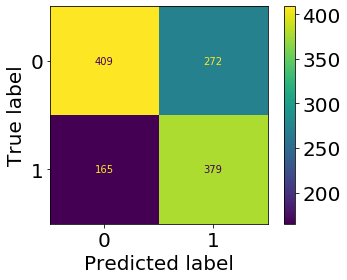

In [28]:
from sklearn.metrics import plot_confusion_matrix
#Best: 0.656406 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'n_estimators': 100}
model = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=10, max_features=5, n_estimators=100, random_state=2)
model.fit(X_train, y_train)
y_predict_rf = model.predict(X_test)
f1_rf = f1_score(y_test, y_predict_rf)
print(f1_rf)
plot_confusion_matrix(model, X_test, y_test)

f1rf_original = f1_rf

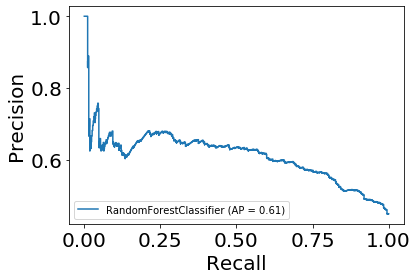

In [29]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(model, X_test, y_test)

### Plot feature importances for Random Forest

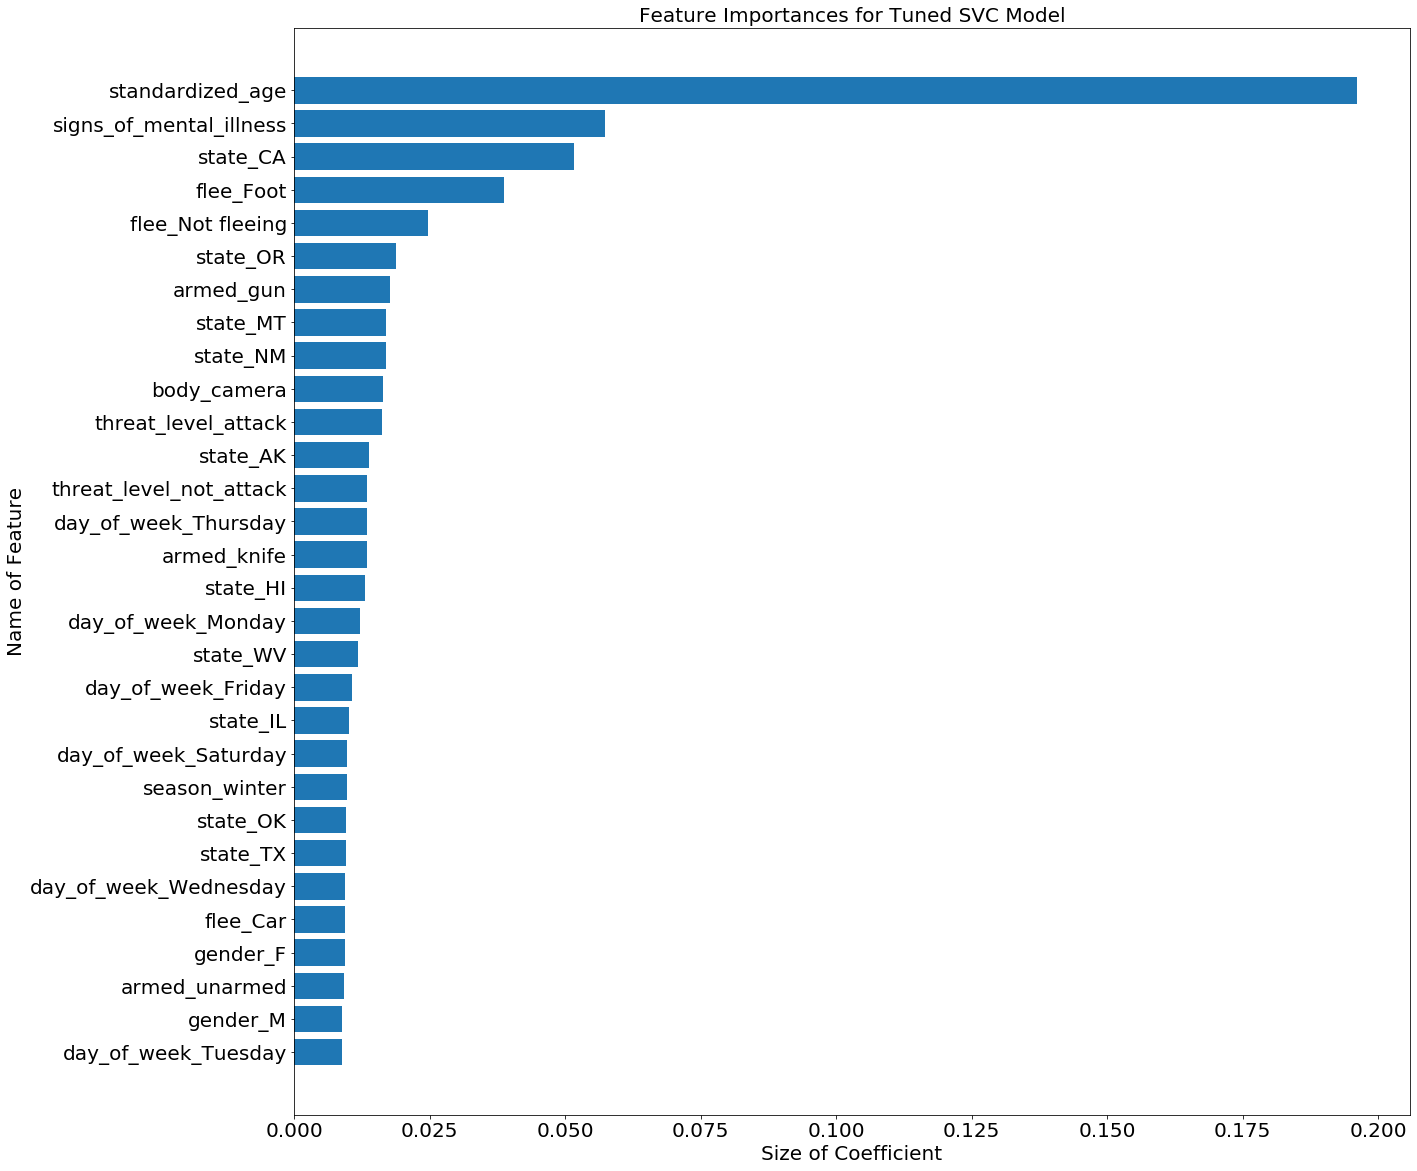

In [30]:
feature_names = X_test.columns[model.feature_importances_.argsort()[-30:]]
importances = np.sort(model.feature_importances_)[-30:]
f_importances(importances, feature_names)

#### This is hard to read because after the first 4 features, all the rest are similar. It also contradicts some of the features highlighted using the Logistics Regression model and the SVM model. Again, 'MT' shows up here but Montana had zero Black or Hispanic people in the fatal encounters dataset. 

### Random Forest GridSearch with Resampled Data

In [ ]:
start = timer()
model = RandomForestClassifier()
max_depth = [5,10,15,20,30]
criterion=['gini','entropy']
n_estimators = [50, 100, 150, 200]
max_features= [5, 10, 15, 20, 30]
class_weight=['balanced']
grid = dict(max_depth=max_depth, n_estimators=n_estimators, class_weight= class_weight, max_features=max_features, criterion=criterion)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1')
grid_result = grid_search.fit(X_train_res, y_train_res)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

end = timer()
print(end - start)

#### Top 10 GridSearch Results for Resampled Training Data 

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

scores=[]
parameters=[]

for mean, stdev, param in zip(means, stds, params):
    scores.append(mean)
    parameters.append(param)
    
scores= np.array(scores)
params=np.array(params)
scores.argsort()[-10:]

ps = params[scores.argsort()[-10:]]
ss = scores[scores.argsort()[-10:]]

for p, s in zip(ps, ss):
    print(s, ':', p)

#### Using best model parameters on test data

F1: 0.6330814441645675


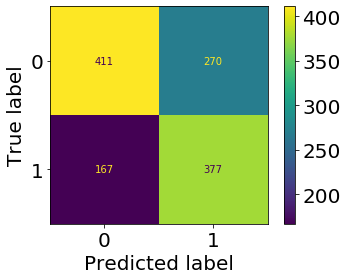

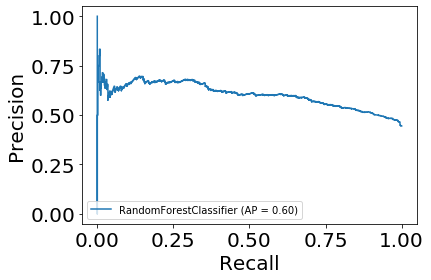

In [31]:
#best model for test data was 3rd best GridSearch model
model = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                               max_depth=20, max_features=10, n_estimators=200, random_state=2)
model.fit(X_train_res, y_train_res)
y_predict_rf = model.predict(X_test)
f1 = (f1_score(y_test, y_predict_rf))
print('F1:', f1)
plot_confusion_matrix(model, X_test, y_test)
plot_precision_recall_curve(model, X_test, y_test)

f1rf_resampled = f1

####  Plotting feature importance for Random Forest trained on a Resampled Model

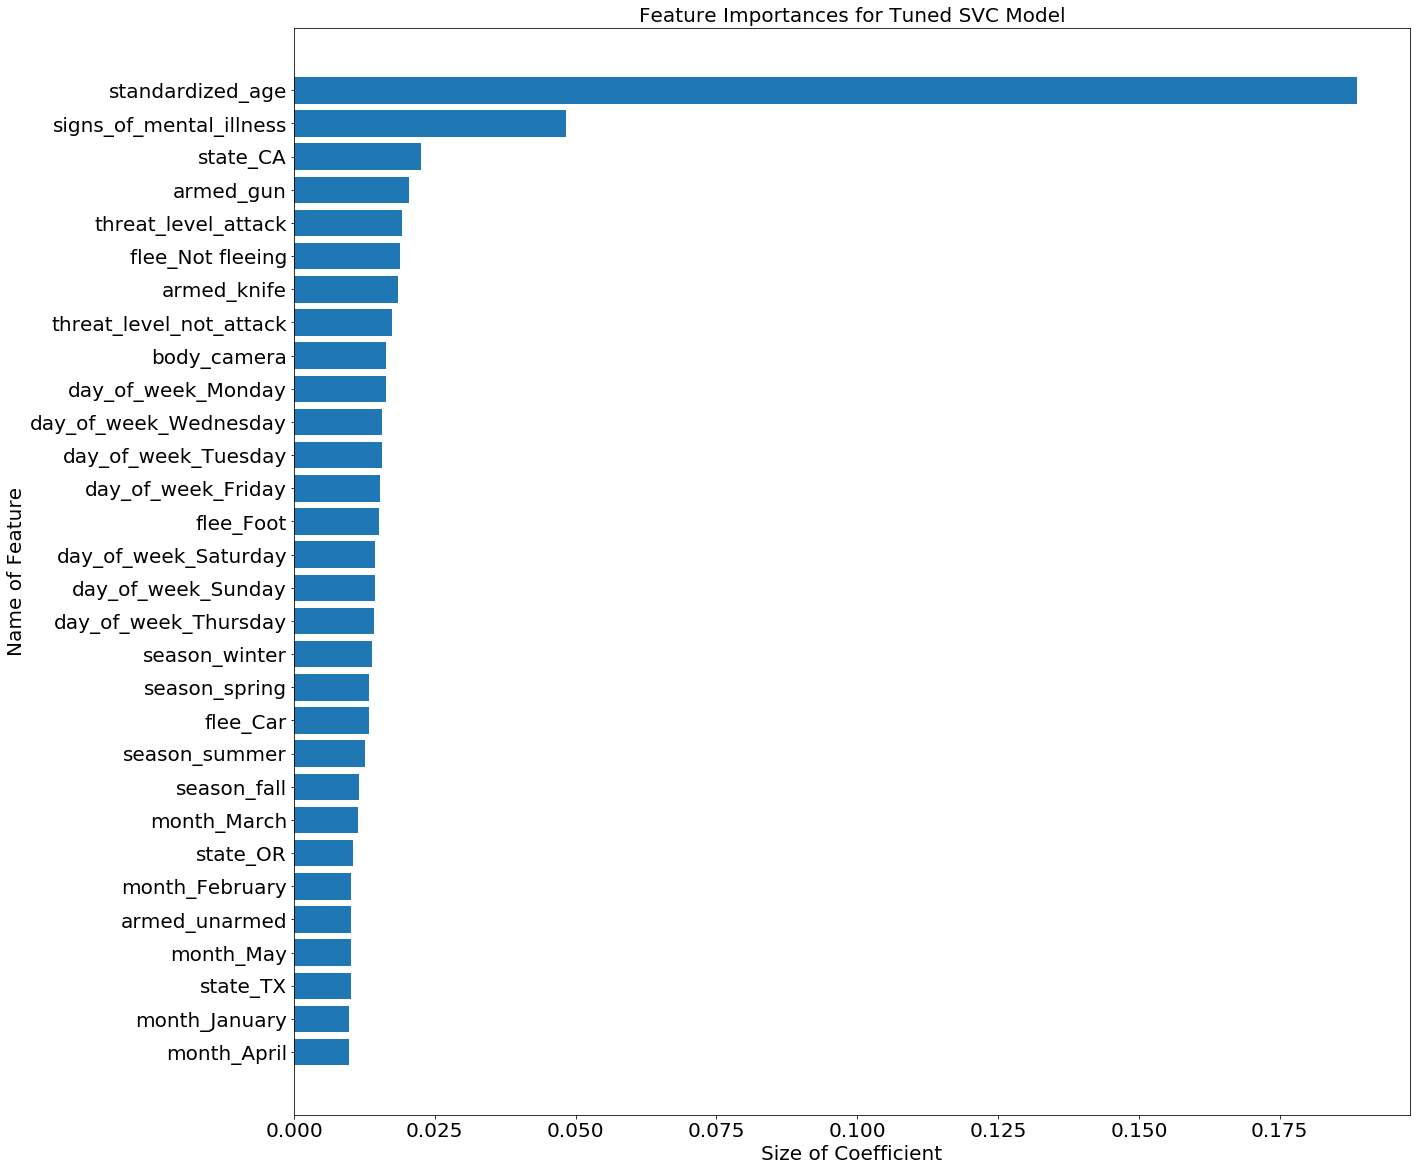

In [32]:
feature_names = X_test.columns[model.feature_importances_.argsort()[-30:]]
importances = np.sort(model.feature_importances_)[-30:]
f_importances(importances, feature_names)

Like Gradient Boost, this model highlights normalized age and signs of mental illness as important factors in deciding whether a victim will be Black or Hispanic. 

The appearance of this plot of features importances suggests to me that the model may need additional normalization, as over 20 features all have a coefficient between 0.1 and 0.25. Included in these 20 features is every single day-of-week features (meaning that day of week is rather meaningless), every season, and 3/4 of the values for in the original 'flee' column. Although the performance of this model has somewhat improved from its out-of-the-box performance, just like GBC, the feature importances given may not be as useful as those given by SVC and LR models.

#### Summary Random Forest: 

In [33]:
print('F1 of out-of-the-box model (in other notebook): 0.595057')
print('F1 of first tuned model:', f1rf_original)
print('F1 Score, post-resampling and retuning:', f1rf_resampled)

F1 of out-of-the-box model (in other notebook): 0.595057
F1 of first tuned model: 0.6343096234309623
F1 Score, post-resampling and retuning: 0.6330814441645675


In [34]:
df2 = pd.read_csv('summary_gbc_lr.csv', index_col=0)


### Summary of all models tested

In [35]:
df2['Regularized F1'] = np.nan
df2.loc[2, 2:] = f1_original, f1_resampled, f1_resampled_retuned, f1_score_retuned
df2.loc[3, 2:] = f1rf_original, f1rf_resampled, np.nan, np.nan
df2 = df2[['Model','Out of the Box F1', 'First Tuned F1', 'Regularized F1', 'Oversampled F1', 'Oversampled and Regularized F1']]
df2

,Model,Out of the Box F1,First Tuned F1,Regularized F1,Oversampled F1,Oversampled and Regularized F1
0,gbc,0.598901,0.610449,NaN,0.648026,NaN
1,lr,0.637523,0.634234,NaN,0.645161,0.623838
2,svc,0.637343,0.652927,0.650502,0.633452,0.640960
3,rf,0.568684,0.634310,NaN,0.633081,NaN


In [36]:
df2.to_csv('summary_all_models.csv')